In [28]:
import argparse
from datasets import get_dataset, DATASETS, get_num_classes
from core import Smooth
from time import time
import torch
from architectures import get_architecture
import datetime

import numpy as np
from find_jacobian import find_jacobian

from scipy.stats import gmean

import math

from torch.autograd.gradcheck import zero_gradients

from torch.utils.data import DataLoader

import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import torch.nn as nn

from seaborn import heatmap

In [2]:
def find_jacobian(inputs, output):
	"""
	:param inputs: Batch X Size (e.g. Depth X Width X Height)
	:param output: Batch X Classes
	:return: jacobian: Batch X Classes X Size
	"""
	assert inputs.requires_grad

	num_classes = output.size()[0]

	jacobian = torch.zeros(num_classes, *inputs.size())
	grad_output = torch.zeros(*output.size())
	if inputs.is_cuda:
		grad_output = grad_output.cuda()
		jacobian = jacobian.cuda()

	for i in range(num_classes):
		zero_gradients(inputs)
		grad_output.zero_()
		grad_output[i] = 1
		output.backward(grad_output, retain_graph=True)
		jacobian[i] = inputs.grad.data

	return jacobian

In [3]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, second_layer, num_classes, noise_std, nonlinear):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.LeakyReLU(negative_slope = 0.1) #leaky relu to keep invertible
        self.fc2 = nn.Linear(hidden_size, second_layer)
        self.fc3 = nn.Linear(second_layer, num_classes)
        self.input_size = input_size
        self.noise_std = noise_std
        self.nonlinear = nonlinear
#         geotorch.orthogonal(self.fc1, "weight") #first weight is orthogonal
    
    def forward(self, x):
#         x = x.reshape(-1, self.input_size) #flatten layer
#         if not self.training:
        x = x + self.noise_std[0] * torch.randn_like(x) #add noise to data
        h1 = self.fc1(x)
        if self.nonlinear:
            h1 = self.relu(h1)
#         if not self.training:
        nh1 = h1 + self.noise_std[1] * torch.randn_like(h1) #add noise to hidden layer
        h2 = self.fc2(nh1)
        h2 = self.relu(h2)
        out = self.fc3(h2)
        return out, h1

In [4]:
def flex_tuple(x):
    if isinstance(x, tuple):
        return x[0]
    else:
        return x

In [5]:
DATASET = "mnist"
NOISE_STD = [0.12, 0.12]
HSIZE = 444
checkpoint = torch.load("../mnist_models/linear/hlayer" + str(HSIZE) + "/0.5-0.5/checkpoint.pth.tar")
base_classifier = get_architecture(checkpoint["arch"], DATASET, noise_std = NOISE_STD, hidden_size = HSIZE)
base_classifier.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [74]:
tst_lst = [param.cpu().detach().numpy() for param in base_classifier.parameters()]
A = tst_lst[0]
R = np.transpose(A) @ np.linalg.inv(A @ np.transpose(A))
B = (NOISE_STD[1] ** 2) * (R @ np.transpose(R)) + (NOISE_STD[0] ** 2) * np.identity(444) #pullback noise
F = (NOISE_STD[1] ** 2) * np.identity(HSIZE) + (NOISE_STD[0] ** 2) * (A @ np.transpose(A)) #pushforward noise

In [7]:
baseB = (R @ np.transpose(R))
baseF = (A @ np.transpose(A))

In [8]:
eigbB, _ = np.linalg.eig(baseB)

In [9]:
eigbF, _ = np.linalg.eig(baseF)

In [10]:
def pbTr(inp, hid):
    return (inp ** 2) + (hid ** 2) * np.mean(eigbB)

In [11]:
def pbDet(inp, hid):
    return gmean(np.sqrt((inp ** 2) + (hid ** 2) * eigbB))

In [12]:
def pfTr(inp, hid):
    return (inp ** 2) * np.mean(eigbF) + (hid ** 2)

In [13]:
def pfDet(inp, hid):
    return gmean(np.sqrt((inp ** 2) * eigbF + (hid ** 2)))

In [14]:
delta = 0.025
LEVELS = 12
x = np.arange(delta, 1, delta)
y = np.arange(0, 1, delta)
X, Y = np.meshgrid(x, y)
Zbt = pbTr(X,Y)
Zbd = np.array([[pbDet(a,b) for a in x] for b in y])
Zft = pfTr(X,Y)
Zfd = np.array([[pfDet(a,b) for a in x] for b in y])

<ipython-input-13-600f06099f3c>:2: RuntimeWarning: invalid value encountered in sqrt
  return gmean(np.sqrt((inp ** 2) * eigbF + (hid ** 2)))


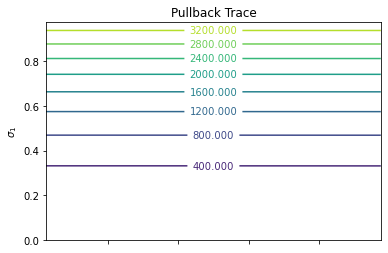

In [41]:
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Zbt, levels = LEVELS - 2)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Pullback Trace')
ax.set_ylabel("$\sigma_1$")
ax.set_xticklabels([])
plt.savefig("Pbtr.pdf")

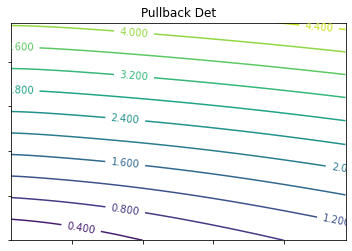

In [42]:
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Zbd, levels = LEVELS)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Pullback Det')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig("Pbdet.pdf")

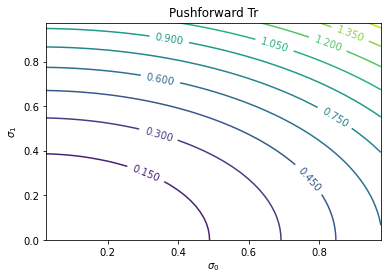

In [43]:
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Zft, levels = LEVELS + 2)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Pushforward Tr')
ax.set_xlabel("$\sigma_0$")
ax.set_ylabel("$\sigma_1$")
plt.savefig("Pftr.pdf")

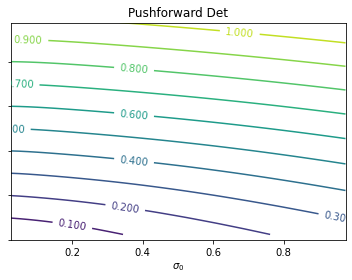

In [44]:
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Zfd, levels = LEVELS)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Pushforward Det')
ax.set_xlabel("$\sigma_0$")
ax.set_yticklabels([])
plt.savefig("Pfdet.pdf")

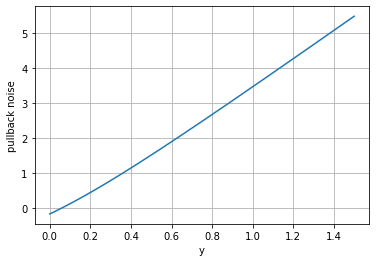

The solution is y = 0.055902
at which the value of the expression is -0.000000


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Define the expression whose roots we want to find

func = lambda y : pbDet(1, y) - pbDet(0.25, 0.25)
# Plot it

y = np.linspace(0, 1.5, 201)

plt.plot(y, [func(b) for b in y])
plt.xlabel("y")
plt.ylabel("pullback noise")
plt.grid()
plt.show()

# Use the numerical solver to find the roots

y_initial_guess = 0.25
y_solution = fsolve(func, y_initial_guess)

print("The solution is y = %f" % y_solution)
print("at which the value of the expression is %f" % func(y_solution))

In [49]:
def find_contour(x, x0 = 0.25, y0 = 0.25):
    func = lambda y : pbDet(x, y) - pbDet(x0, y0)
    y_sol = fsolve(func, y0)
    return y_sol[0]

In [72]:
inp_arr = [0.12, 0.25, 0.5, 1]
trial_vals = [(i, find_contour(i, x0 = 0.12, y0 = 0.12)) for i in inp_arr]

In [73]:
trial_vals

[(0.12, 0.12000000726508035),
 (0.25, 0.09395022866251423),
 (0.5, 0.020015942784419406),
 (1, 2.869959295236567e-06)]

In [59]:
pbDet(0.12, 0.12)

0.5560959

In [69]:
pbDet(0.25, 0.25)

1.1585331

In [70]:
pbDet(0.5, 0.5)

2.3170662

In [71]:
pbDet(1, 1)

4.6341324

<ipython-input-13-600f06099f3c>:2: RuntimeWarning: invalid value encountered in sqrt
  return gmean(np.sqrt((inp ** 2) * eigbF + (hid ** 2)))


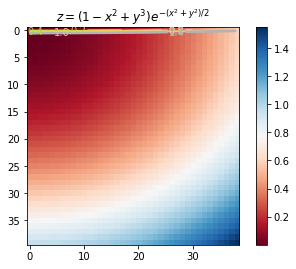

In [35]:
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# the function that I'm going to plot
def z_func(x,y):
    return (1-(x**2+y**3))*exp(-(x**2+y**2)/2)
 
delta = 0.025
LEVELS = 12
x = np.arange(delta, 1, delta)
y = np.arange(0, 1, delta)
X, Y = np.meshgrid(x, y)
Zbt = pbTr(X,Y)
Zbd = np.array([[pbDet(a,b) for a in x] for b in y])
Zft = pfTr(X,Y)
Zfd = np.array([[pfDet(a,b) for a in x] for b in y])

im = imshow(Zft,cmap=cm.RdBu) # drawing the function
# adding the Contour lines with labels
cset = contour(Zbt,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
colorbar(im) # adding the colobar on the right
# latex fashion title
title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')
show()

In [24]:
1 / delta

40.0

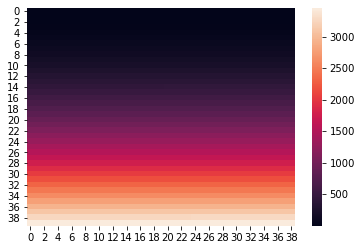

In [34]:
heatmap(Zbt)

In [30]:
X

array([[0.025, 0.05 , 0.075, ..., 0.925, 0.95 , 0.975],
       [0.025, 0.05 , 0.075, ..., 0.925, 0.95 , 0.975],
       [0.025, 0.05 , 0.075, ..., 0.925, 0.95 , 0.975],
       ...,
       [0.025, 0.05 , 0.075, ..., 0.925, 0.95 , 0.975],
       [0.025, 0.05 , 0.075, ..., 0.925, 0.95 , 0.975],
       [0.025, 0.05 , 0.075, ..., 0.925, 0.95 , 0.975]])